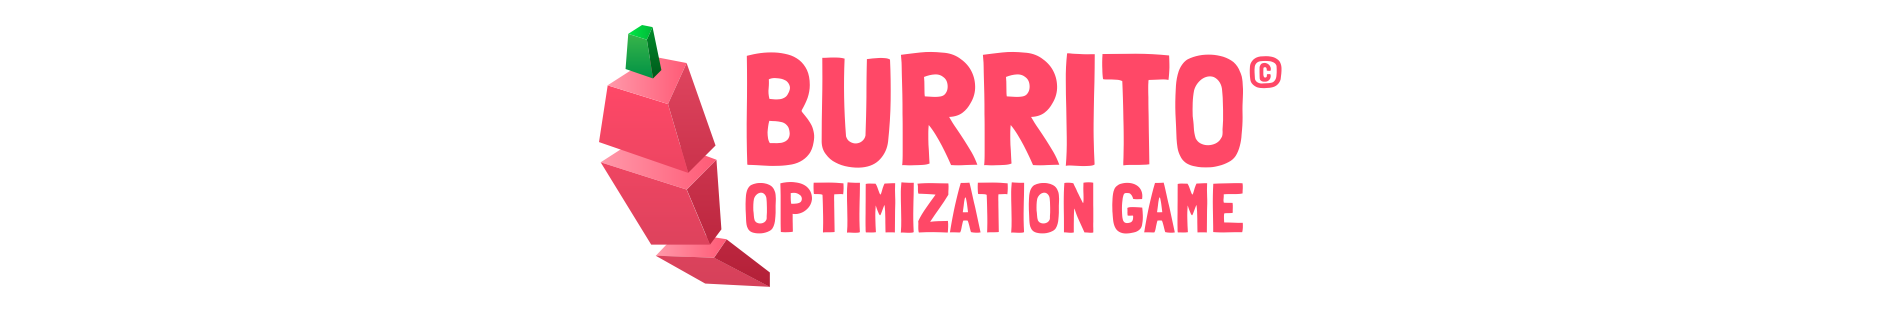
<center><a target="_blank" href="https://www.burritooptimizationgame.com/">BurritoOptimizationGame.com</a></center>
<center><a target="_blank" href="https://www.gurobi.com/lp/academics/burrito-optimization-game-guide/#optimal-solutions">Game Guide</a>  |  <a target="_blank" href="https://www.gurobi.com/lp/academics/burrito-optimization-teaching-guide/">Teaching Guide</a></center>
<center>Notebook by Alison Cozad  | <a target="_blank" href="https://www.gurobi.com/lp/academics/burrito-optimization-game-guide/#who-built-this">Game credits</a></center>


The Burrito Optimization Game is an educational game designed to introduce students to the power of optimization. In the game, the player places burrito trucks on a city map to earn as much profit as possible. In playing the game, the player is essentially solving an optimization problem “by hand.” The game is designed to introduce players to optimization—what it is, what it’s useful for, and why it’s hard to do by hand. To play the game, you must be logged in to your Gurobi account.

In this notebook, we will learn how to write the Burrito game optimization model for any day in Round 1 using the data downloaded from the game.

This modeling tutorial is at the introductory level, where we assume that you know Python and have a background in a discipline that uses quantitative methods.  

Here are a few handy resources to have ready:
- [Gurobi Python Documentation](https://www.gurobi.com/documentation/9.5/refman/py_python_api_overview.html)
- [Gurobi Python Examples](https://www.gurobi.com/documentation/9.5/examples/python_examples.html)
- [Burrito Optimization Game: Teaching Guide](https://www.gurobi.com/lp/academics/burrito-optimization-teaching-guide/)
- [Burrito Optimization Game: Game Guide](https://www.gurobi.com/lp/academics/burrito-optimization-game-guide/)

---

## Problem description

Guroble has just set up business in Burritoville! Guroble needs your assistance planning where to place its burrito trucks to serve hungry customers throughout the city and maximize its profit. Truck placement has to be carefully planned because every truck has a cost, but its ability to earn revenue depends on how close it is to potential customers.

### Your task in the game:
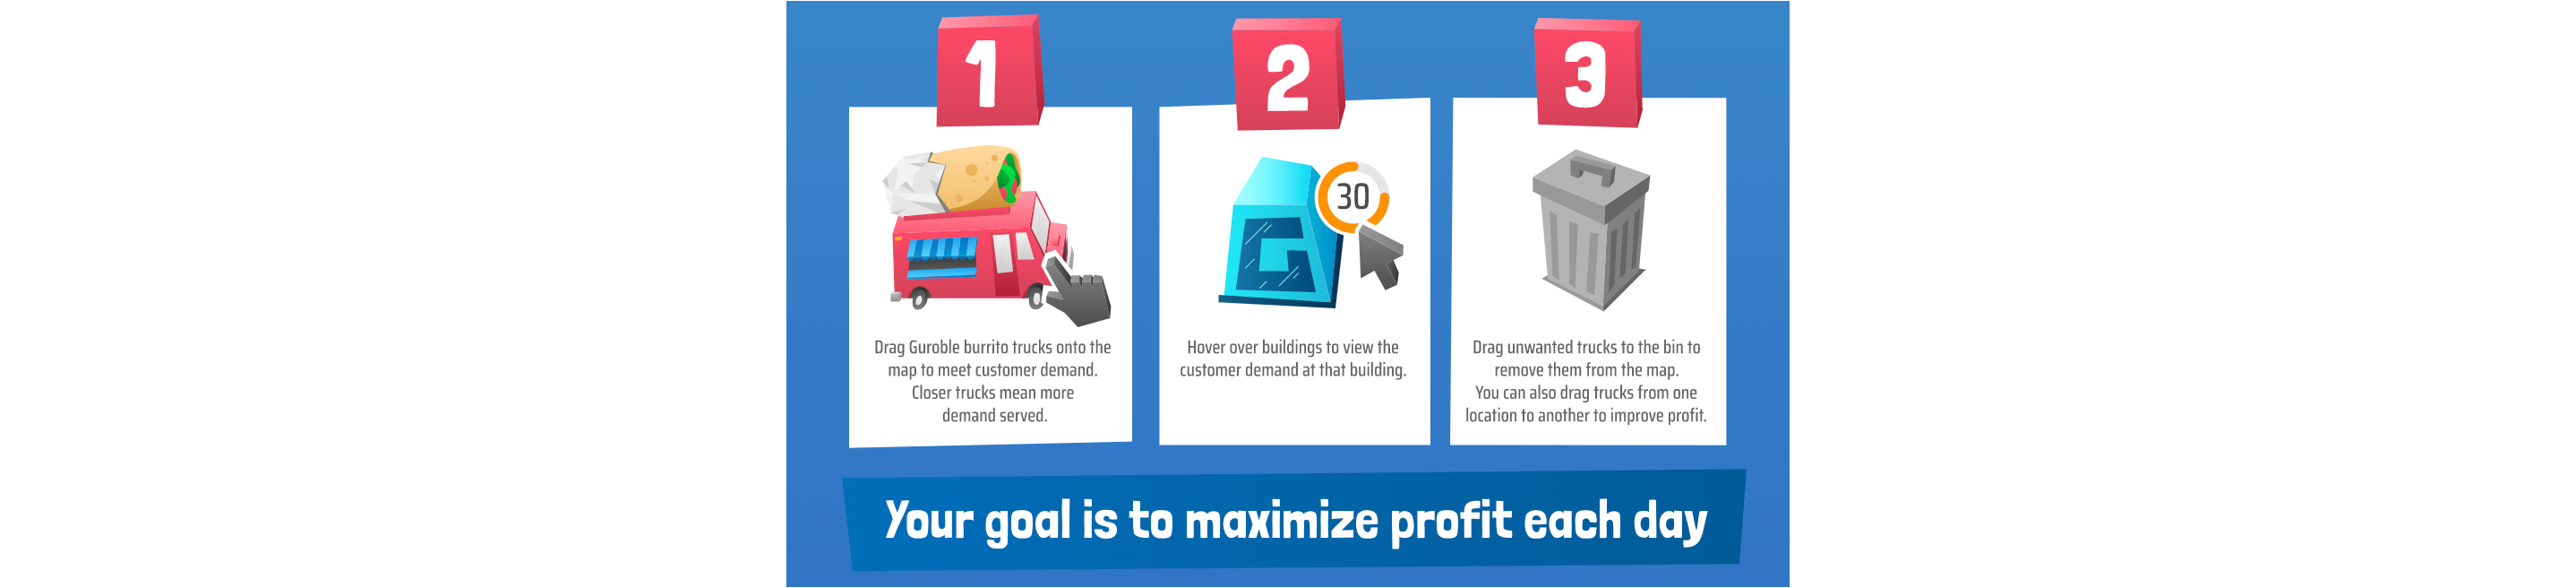

### Your task in this notebook: 
Write a model to select the optimal burrito truck placement to maximize profits.  You will be solving for one day in Round 1.


---

## Before you dive into this model, 
If you haven't already, we recommend playing Days 1 and 2 in Round 1 of the [BurritoOptimizationGame.com](https://www.burritooptimizationgame.com/) to learn about Burritoville and the problem we are trying to solve.  Then, ask yourself:
- What seems easy or hard about locating burrito trucks? 
- Did you find a solution that was close to optimal?
- Should you order a burrito now or wait until you are done with this notebook?
- What strategy did you use? I bet you wish you had your own optimization model, eh? (Cue shameless promotion of this Jupyter Notebook).

## Let's get started
Throughout the rest of this notebook, we will
1. Define the data structures
1. Create the Gurobi `model` object
1. Add decision variables
1. Add constraints
1. Set the objective function
1. Solve the model
1. Retrieve solution values



## 0. The obligatory part
I know this wasn't on the list that I just gave you. Alas, this is the obligatory part of all python code: installing importing packages.  You are encouraged to completely forget this part and copy-and-paste it for each new Gurobi model you write.  ;)

The following Python code imports the Gurobi callable library and imports the `GRB` class into the main namespace.

In [1]:
!pip install gurobipy
!pip install plotly

import gurobipy as gp
from gurobipy import GRB

---

## 1.  Define the data structures

The Burrito Optimization Game lets you download the data to define the model.  To ensure we have time for the fun stuff, we have added this below for you.

Here is the data overlayed on the map:
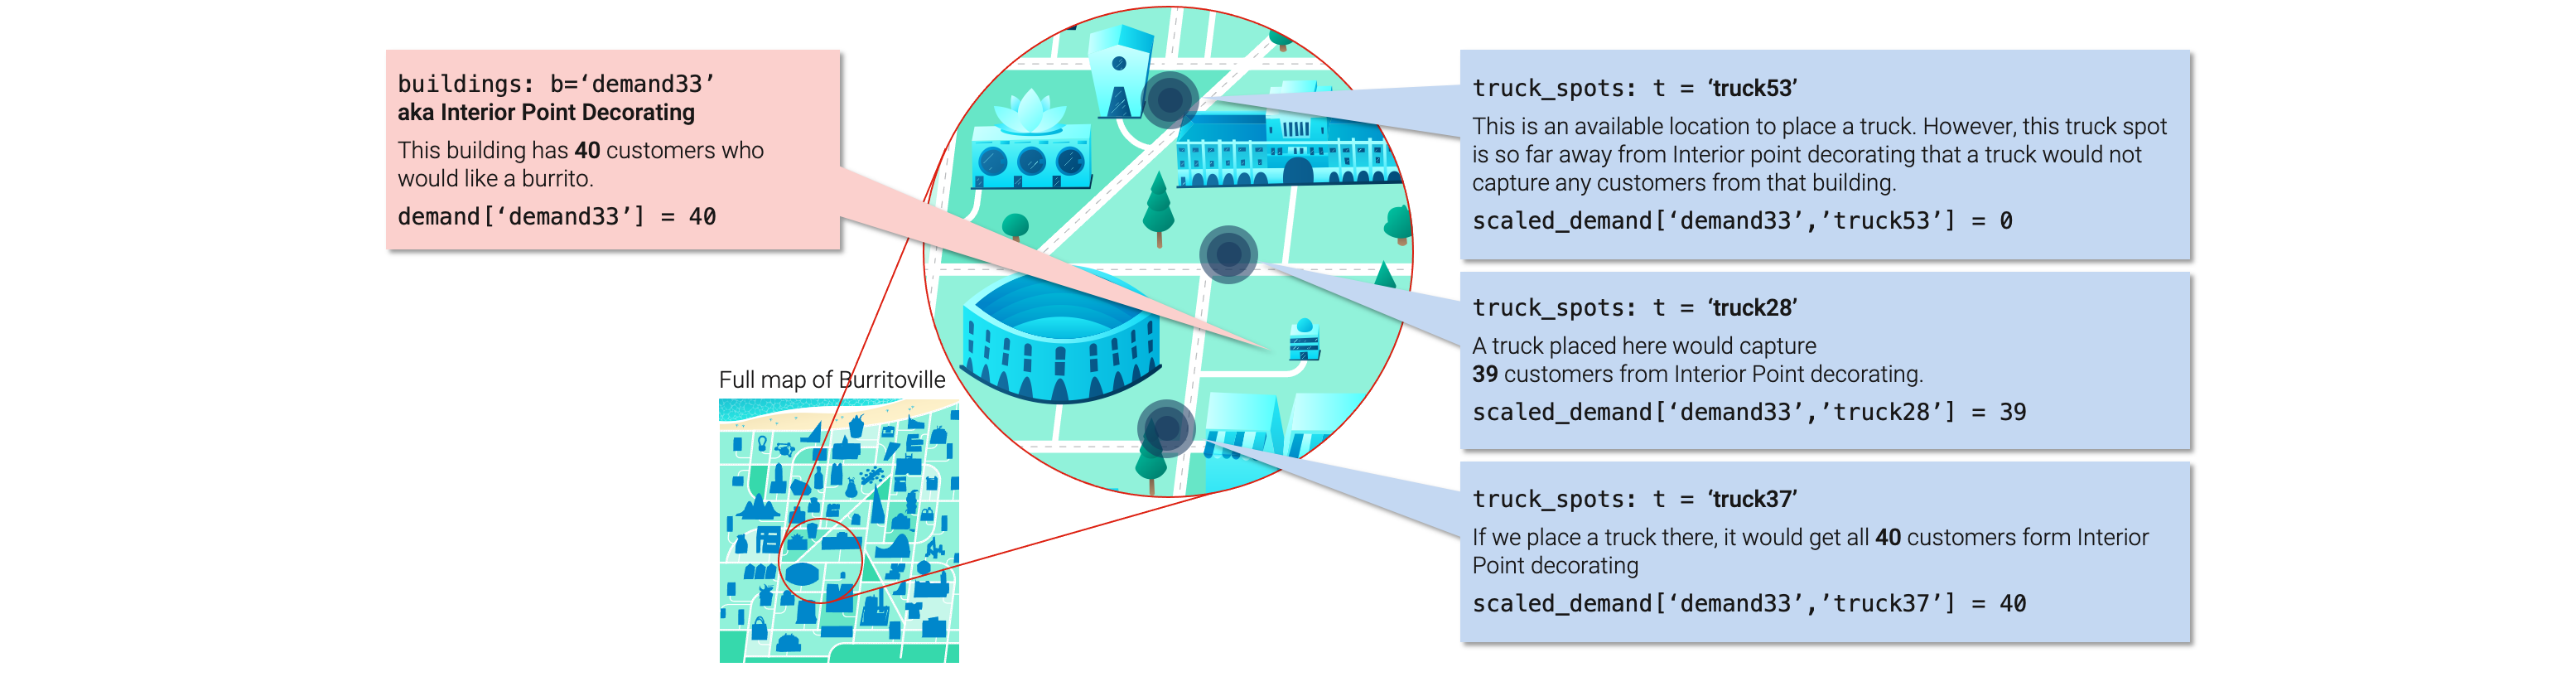

What do we know about Burritoville on a given day?
- Scalar data: `burrito_price`, `ingredient_cost`, and `truck_cost`
- Truck data: Set of trucks spots that are available `truck_spots[t]`
- Buildings that have customer demand: Total demand `demand[b]` and scaled demand by a factor of how far the customer will have to walk `scaled_demand[b,t]`

Other data such as map coordinates and building names are used for plotting only.  In the cells below, we will recreate the BurritoOptimizationGame model using data from CSV files that are downloadable from the game.

To start, pick the round and day that you would like to solve for

In [2]:
# Round and day specific string. Note: This model is only valid for Round 1
path = "BurritoOptimizationGame_Data/"
round_day_str = "round1-day1" ### CHANGE THIS TO SWITCH DAYS. This should match the csv filenames (round1-day1, round1-day2, ...)###

Before I get ahead of myself, I will make sure all the right files exist. 

In [3]:
import os.path

filenames={
    'Problem data': path + round_day_str + "_problem_data.csv",
    'Truck node data': path + round_day_str + "_truck_node_data.csv",
    'Demand node data': path + round_day_str + "_demand_node_data.csv",
    'Demand-Truck data': path + round_day_str + "_demand_truck_data.csv" , 
}

for key, val in filenames.items():
    if os.path.exists(val) == False:
        raise Exception(f"'{key}' csv does not exist: {val}.  Please ensure this is the right path to this file")

print('There were no errors, so we can proceed.')

There were no errors, so we can proceed.


### Read in and define data structures
We will define the following from these data structures:

- From the **'Problem Data'** we will get basic data that will be stored as scalars: `burrito_price`, `ingredient_cost`, and `truck_cost`
- From **'Truck node data'** we are given the possible truck locations and their coordinates on the map.  We will not use the coordinates in the model, but we will use them for plotting. From this, we create the `truck_spots` set and the `truck_coordinates` dictionary.
- From **'Demand node data'** we get a list of buildings with customer demand by building.  We are also given the coordinates and building names --- which we find pretty clever.  We use the Gurobi Python [multidict()](https://www.gurobi.com/documentation/current/refman/py_multidict.html) function to initialize one or more dictionaries with a single statement. The function takes a dictionary as its argument. The keys represent the possible combinations of buildings and truck spots.
- From **'Demand-Truck data'** we get information about how the demand scales with each building location and truck spot pair.  Customers are only willing to walk so far to a burrito truck, and the actual number of customers you win from a building is smaller the farther away the truck is from the building. If the nearest truck is too far away, you won’t win any customers from that building.  To account for this, there is a demand multiplier based on how far a customer can walk from their building to a truck spot.  The scaled demand below is the product of the demand multiplier and the total customer demand at a building.  We will also extract this data using the Gurobi Python [multidict()](https://www.gurobi.com/documentation/current/refman/py_multidict.html) function.  From this, we get the `scaled_demand[b,t]` values.

These data structures are created in the following cell.

In [4]:
import pandas as pd
import csv

# Read in basic problem data
filename = filenames['Problem data']
with open(filename, newline='') as csvfile:
    reader = csv.DictReader(csvfile)    
    for row in reader:
        burrito_price = float(row['burrito_price'])
        ingredient_cost = float(row['ingredient_cost'])
        truck_cost = float(row['truck_cost'])
        break

# Read in truck node data
filename = filenames['Truck node data']
with open(filename, mode='r') as csvfile:
    reader = csv.reader(csvfile)
    truck_coordinates = {rows[0]:(float(rows[1]),float(rows[2])) for rows in reader if rows[0] != 'index'} # truck_spot: (x_coord, y_coord)

truck_spots = truck_coordinates.keys()

# Read in building data
filename = filenames['Demand node data']
with open(filename, mode='r') as csvfile:
    reader = csv.reader(csvfile)
    buildings, building_names, building_coordinates, demand = gp.multidict({
        rows[0]: [rows[1], (float(rows[2]), float(rows[3])), float(rows[4])] for rows in reader if rows[0] != 'index' # building: building_name, (x_coord, y_coord), demand
    })

# Read in paired building and truck data
filename = filenames['Demand-Truck data']
with open(filename, mode='r') as csvfile:
    reader = csv.reader(csvfile)
    building_truck_spot_pairs, distance, scaled_demand = gp.multidict({
        (rows[0], rows[1]): [float(rows[2]), float(rows[3])] for rows in reader if rows[0] != 'demand_node_index' if float(rows[3])>0# (building, truck_spot): distance, scaled_demand
    })


### Current map layout with this data
We can now view this data on our Burritoville map to make sure everything looks correct.


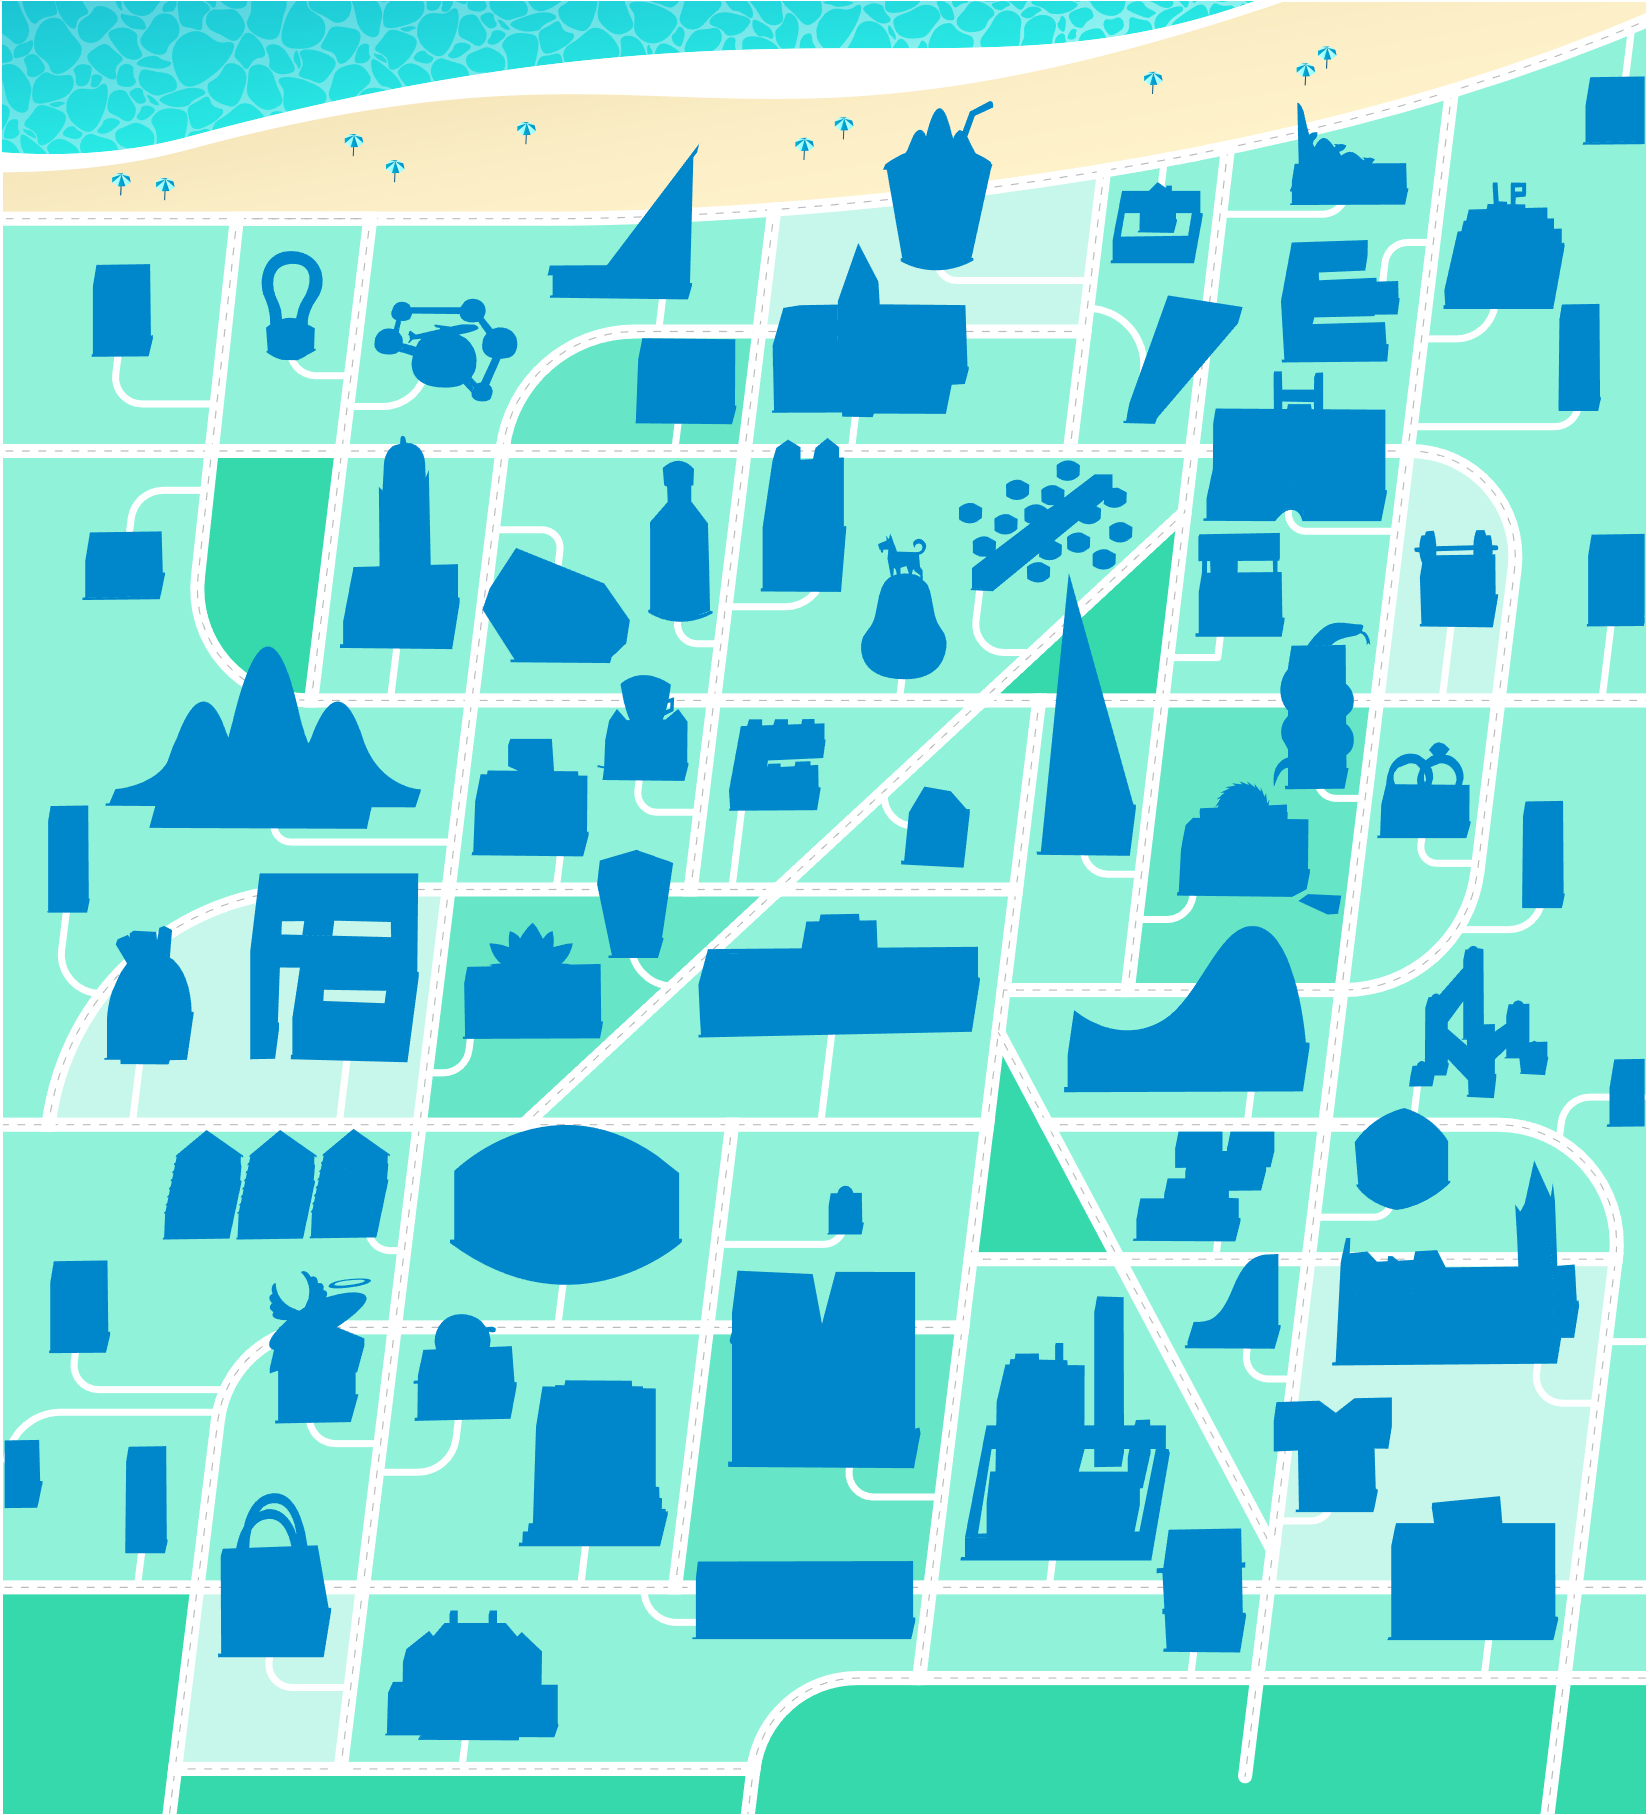

In [5]:
# Plot the truck spots and customer demands on the Burritoville map
from misc.show_map import show_map
show_map(buildings, building_names, building_coordinates, demand, truck_coordinates)

---

## 2. Begin building the model
In the next four steps, we will be creating the following model:
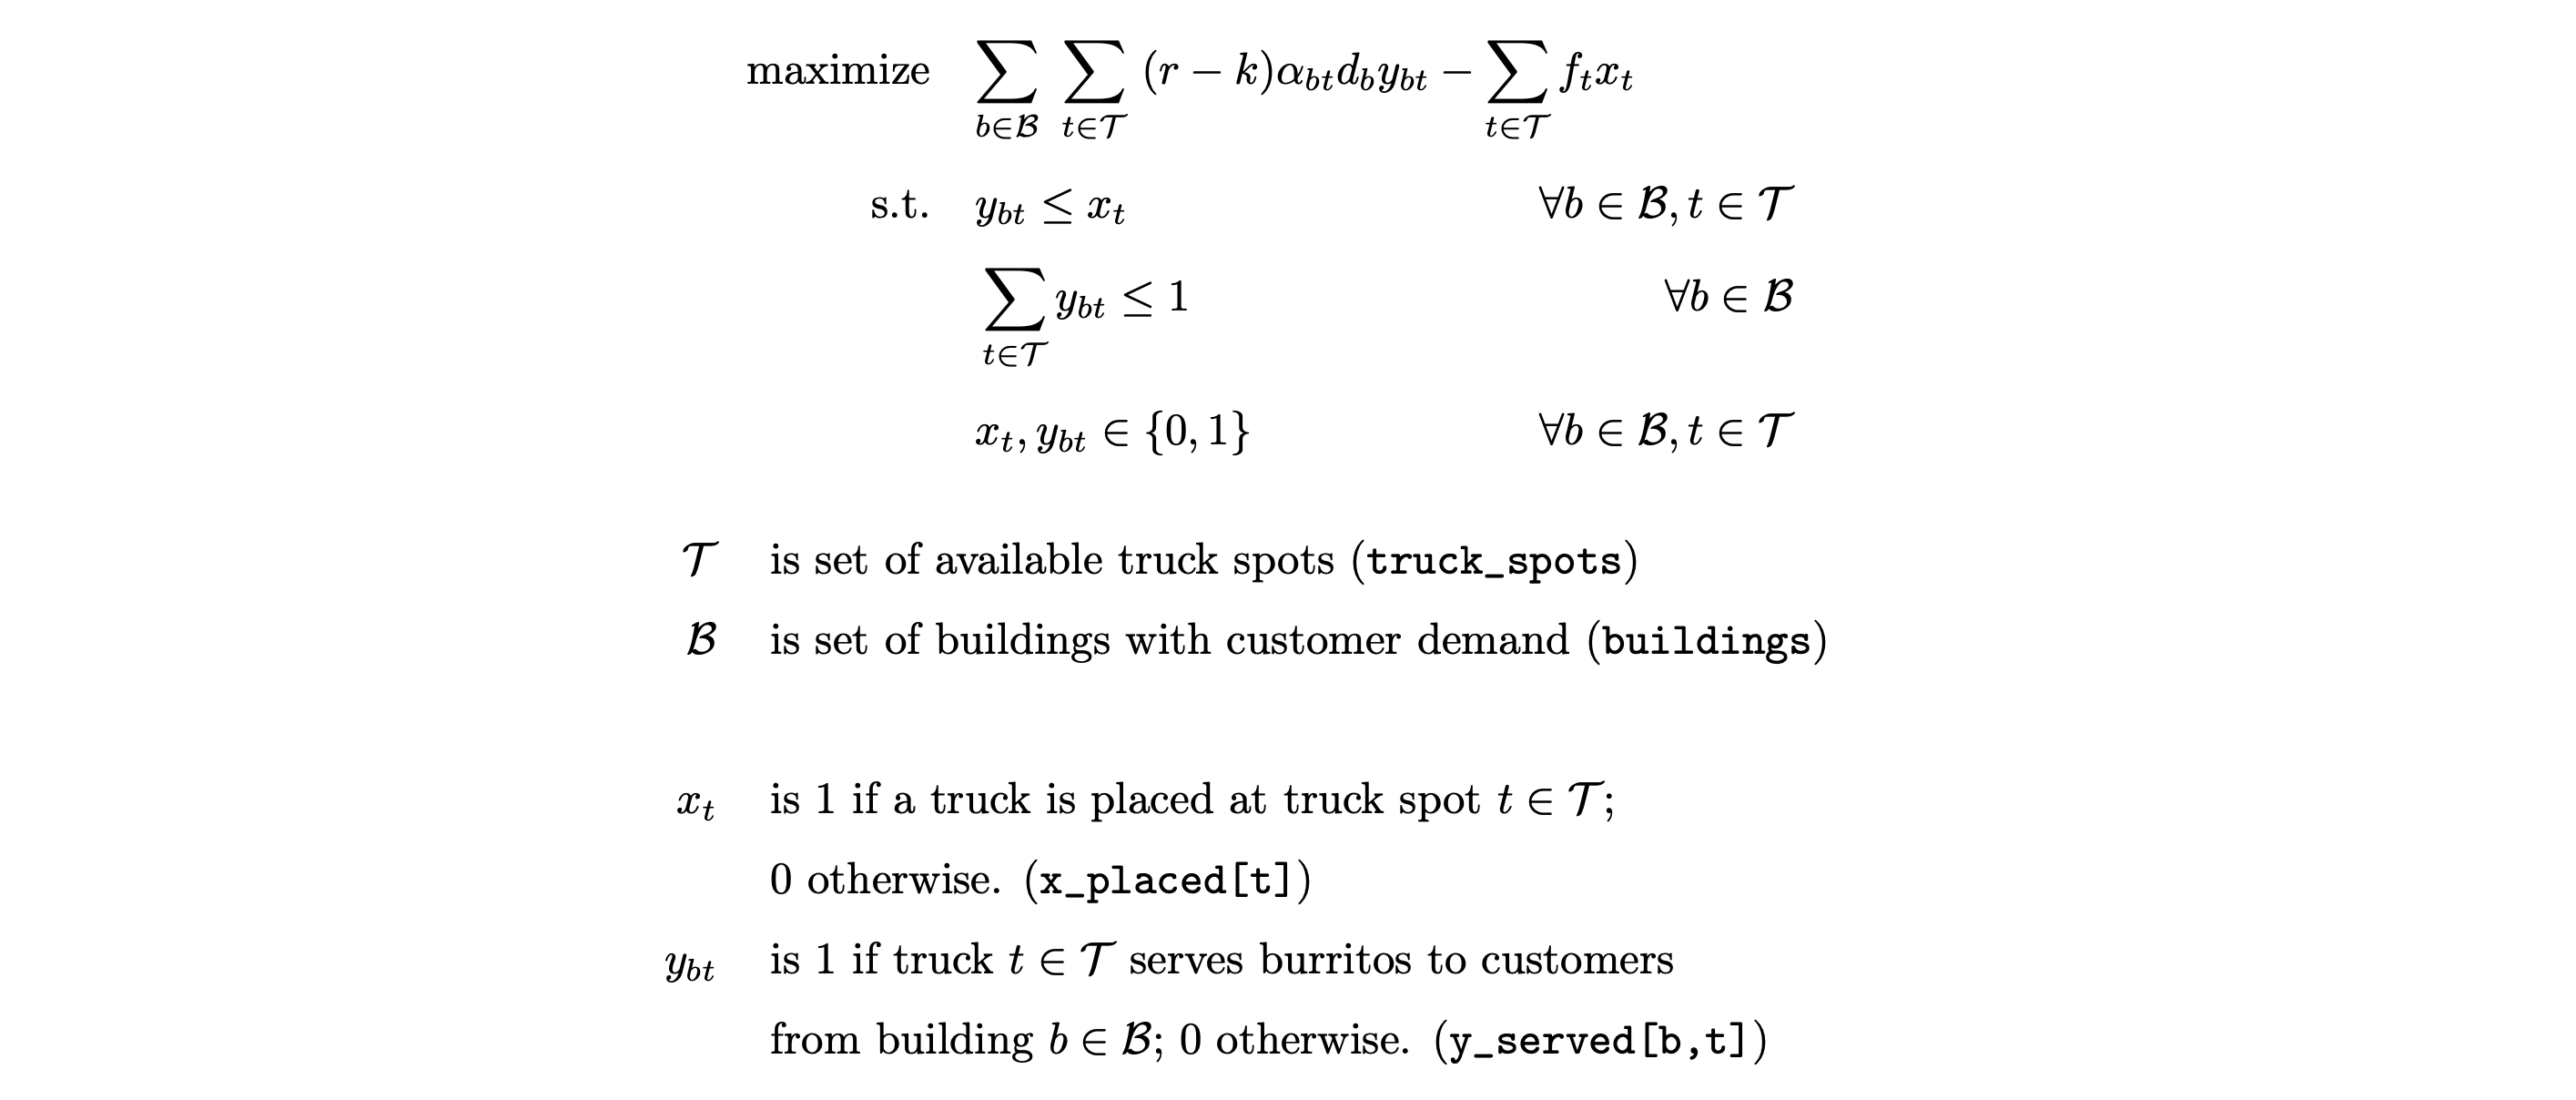

Above, we created these scalars and data structures
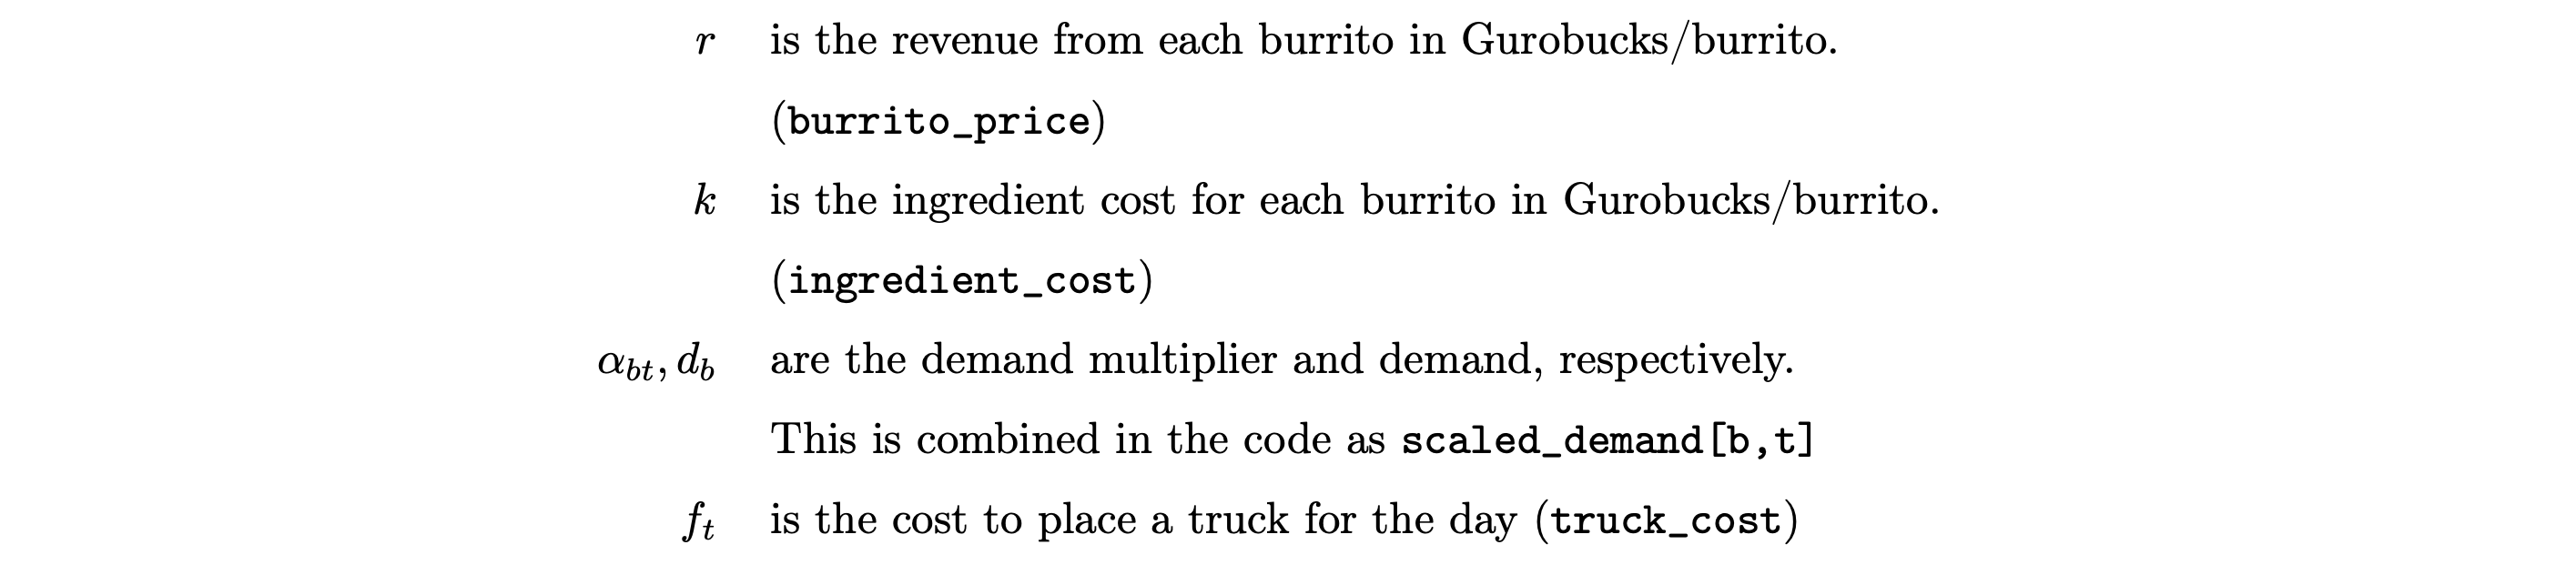

To start, we will need to create the [model()](https://www.gurobi.com/documentation/9.5/refman/py_model2.html) object in Gurobi.  The Model object holds a single optimization problem. It consists of a set of variables, a set of constraints, and the objective function.

*Tip: For python to know to call a `gurobipy` function, you will need to start with `gp` because this is how we defined it above. For example, if you want to call `functionname()`, you would use `gp.functionname()`.*

In [6]:
# Declare and initialize model
model = gp.Model("Burrito Optimization Game")

---

## 3. Add Decision variables
To solve the Burrito Optimization Game problem, we need to identify where we will place our trucks.  Each truck can only be placed in an available truck spot.  We also need to know which buildings will be served by which truck.  Here are the two variables we are creating:

- `x_placed[t]` is 1 if we place a truck at truck spot `t`, otherwise `x_placed[t]` is 0
- `y_served[b,t]` is 1 if building `b` is served by a truck placed at truck spot `t`, otherwise `y_served[b,t]` is 0

Here we are creating variables using [addVars()](https://www.gurobi.com/documentation/current/refman/py_model_addvars.html#pythonmethod:Model.addVars) function for `x_placed` and `y_served`.

In [7]:
# Create decision variables for the Burrito Optimization Game model
x_placed = model.addVars(truck_spots, vtype=GRB.BINARY, name="x_placed")
y_served = model.addVars(building_truck_spot_pairs, vtype=GRB.BINARY, name="y_served")

---
## 4. Add Constraints
We will now begin adding the constraints that define our problem.


### Truck must be open at a truck_spot to serve the customer
Here we must ensure that a truck exists in a truck spot if a customer is served there. No truck, no burrito : (.

In the next cell, we will create these constraints in one call to [addConstrs()](https://www.gurobi.com/documentation/current/refman/py_model_addconstrs.html) to add to the model
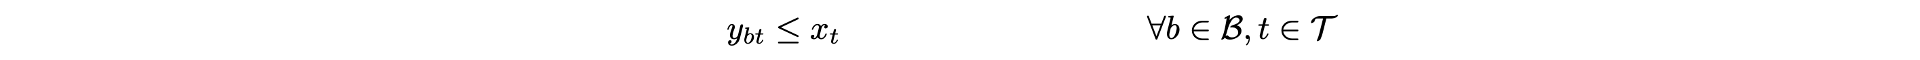

*Tip: There is more than one way to create these constraints.  You can add the constraints one-at-a-time using [addConstr()](https://www.gurobi.com/documentation/current/refman/py_model_addconstr.html) or with one line using [addConstrs()](https://www.gurobi.com/documentation/current/refman/py_model_addconstrs.html).  We have used the latter.*

In [8]:
# Create truck-must-exist constraints
cons1 = model.addConstrs((y_served[b,t] <= x_placed[t] 
                          for b,t in building_truck_spot_pairs), 
                          name = "Ensure_truck_spot_open_to_serve")

### Only one truck per customer at a given building

The customers from one building will all be served by up to one truck. 
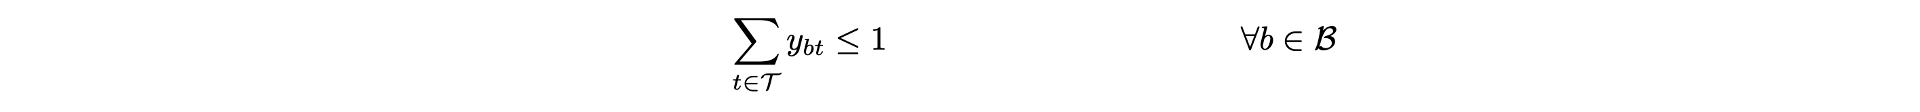

Here we are using the y_served.[sum()](https://www.gurobi.com/documentation/current/refman/py_tupledict_sum.html) function to make it easy to do a summation over a variable.

In [9]:
# Create only one truck per customers at building constraint
cons2 = model.addConstrs((y_served.sum(b,'*') <= 1 for b in buildings), 
                         name="Ensure_one_truck_per_customers_at_building")

---
## 5. Set the objective
The objective is to maximize the total profit.  

To set the objective, we will first define the revenue using a nested summation.  This can be accomplished using the function.  For convenience and readability, we will split the objective into the burrito revenue and truck costs:

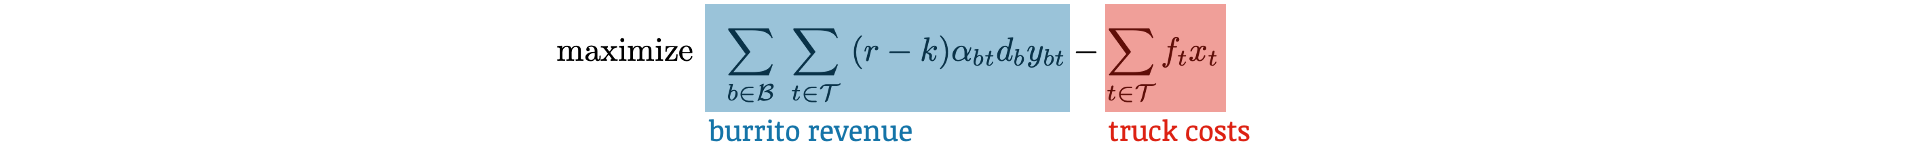

Here, we are only creating new linear expressions, not new variables. Then we will use the [setObjective()](https://www.gurobi.com/documentation/current/refman/py_model_setobjective.html) method to set the objective.

In [10]:
# Objective: maximize total profit = burrito_revenue - total_truck_cost
burrito_revenue = (burrito_price - ingredient_cost)*y_served.prod(scaled_demand) # This is the nested summation
total_truck_cost = truck_cost*x_placed.sum('*')

model.setObjective(burrito_revenue - total_truck_cost, GRB.MAXIMIZE)

### Celebrate and check your work

In [11]:
model.write('burritogame.lp')

---
## 6. Solve the model 
We use the [optimize()](https://www.gurobi.com/documentation/current/refman/py_model_optimize.html) method of the Gurobi/Python API to solve the problem we have defined for the model object `model`.

In [12]:
model.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 128 rows, 129 columns and 339 nonzeros
Model fingerprint: 0x42dc3551
Variable types: 0 continuous, 129 integer (129 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 17 rows and 20 columns
Presolve time: 0.00s
Presolved: 111 rows, 109 columns, 288 nonzeros
Variable types: 0 continuous, 109 integer (109 binary)

Root relaxation: objective 6.000000e+02, 35 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     600.0000000  600.00000  0.00%     -    0s

Explored 1 nodes (35 simplex ite

Before we start digging into the solution, let's check the solution.  If the model is not optimal, check the [Optimization Status Codes](https://www.gurobi.com/documentation/current/refman/optimization_status_codes.html) page.

In [13]:
status = model.status
if status == GRB.OPTIMAL:
    print(f"The final objective is ")
    print(f"     Burrito revenue        ₲{burrito_revenue.getValue()}")
    print(f" -  Total truck cost     -  ₲{total_truck_cost.getValue()}")
    print(f"-----------------------------------")
    print(f"              Profit        ₲{model.objVal}")
else:
    print(f"Model is not optimal, status = {status}")

The final objective is 
     Burrito revenue        ₲1100.0
 -  Total truck cost     -  ₲500.0
-----------------------------------
              Profit        ₲600.0


---
## 7. View the solution



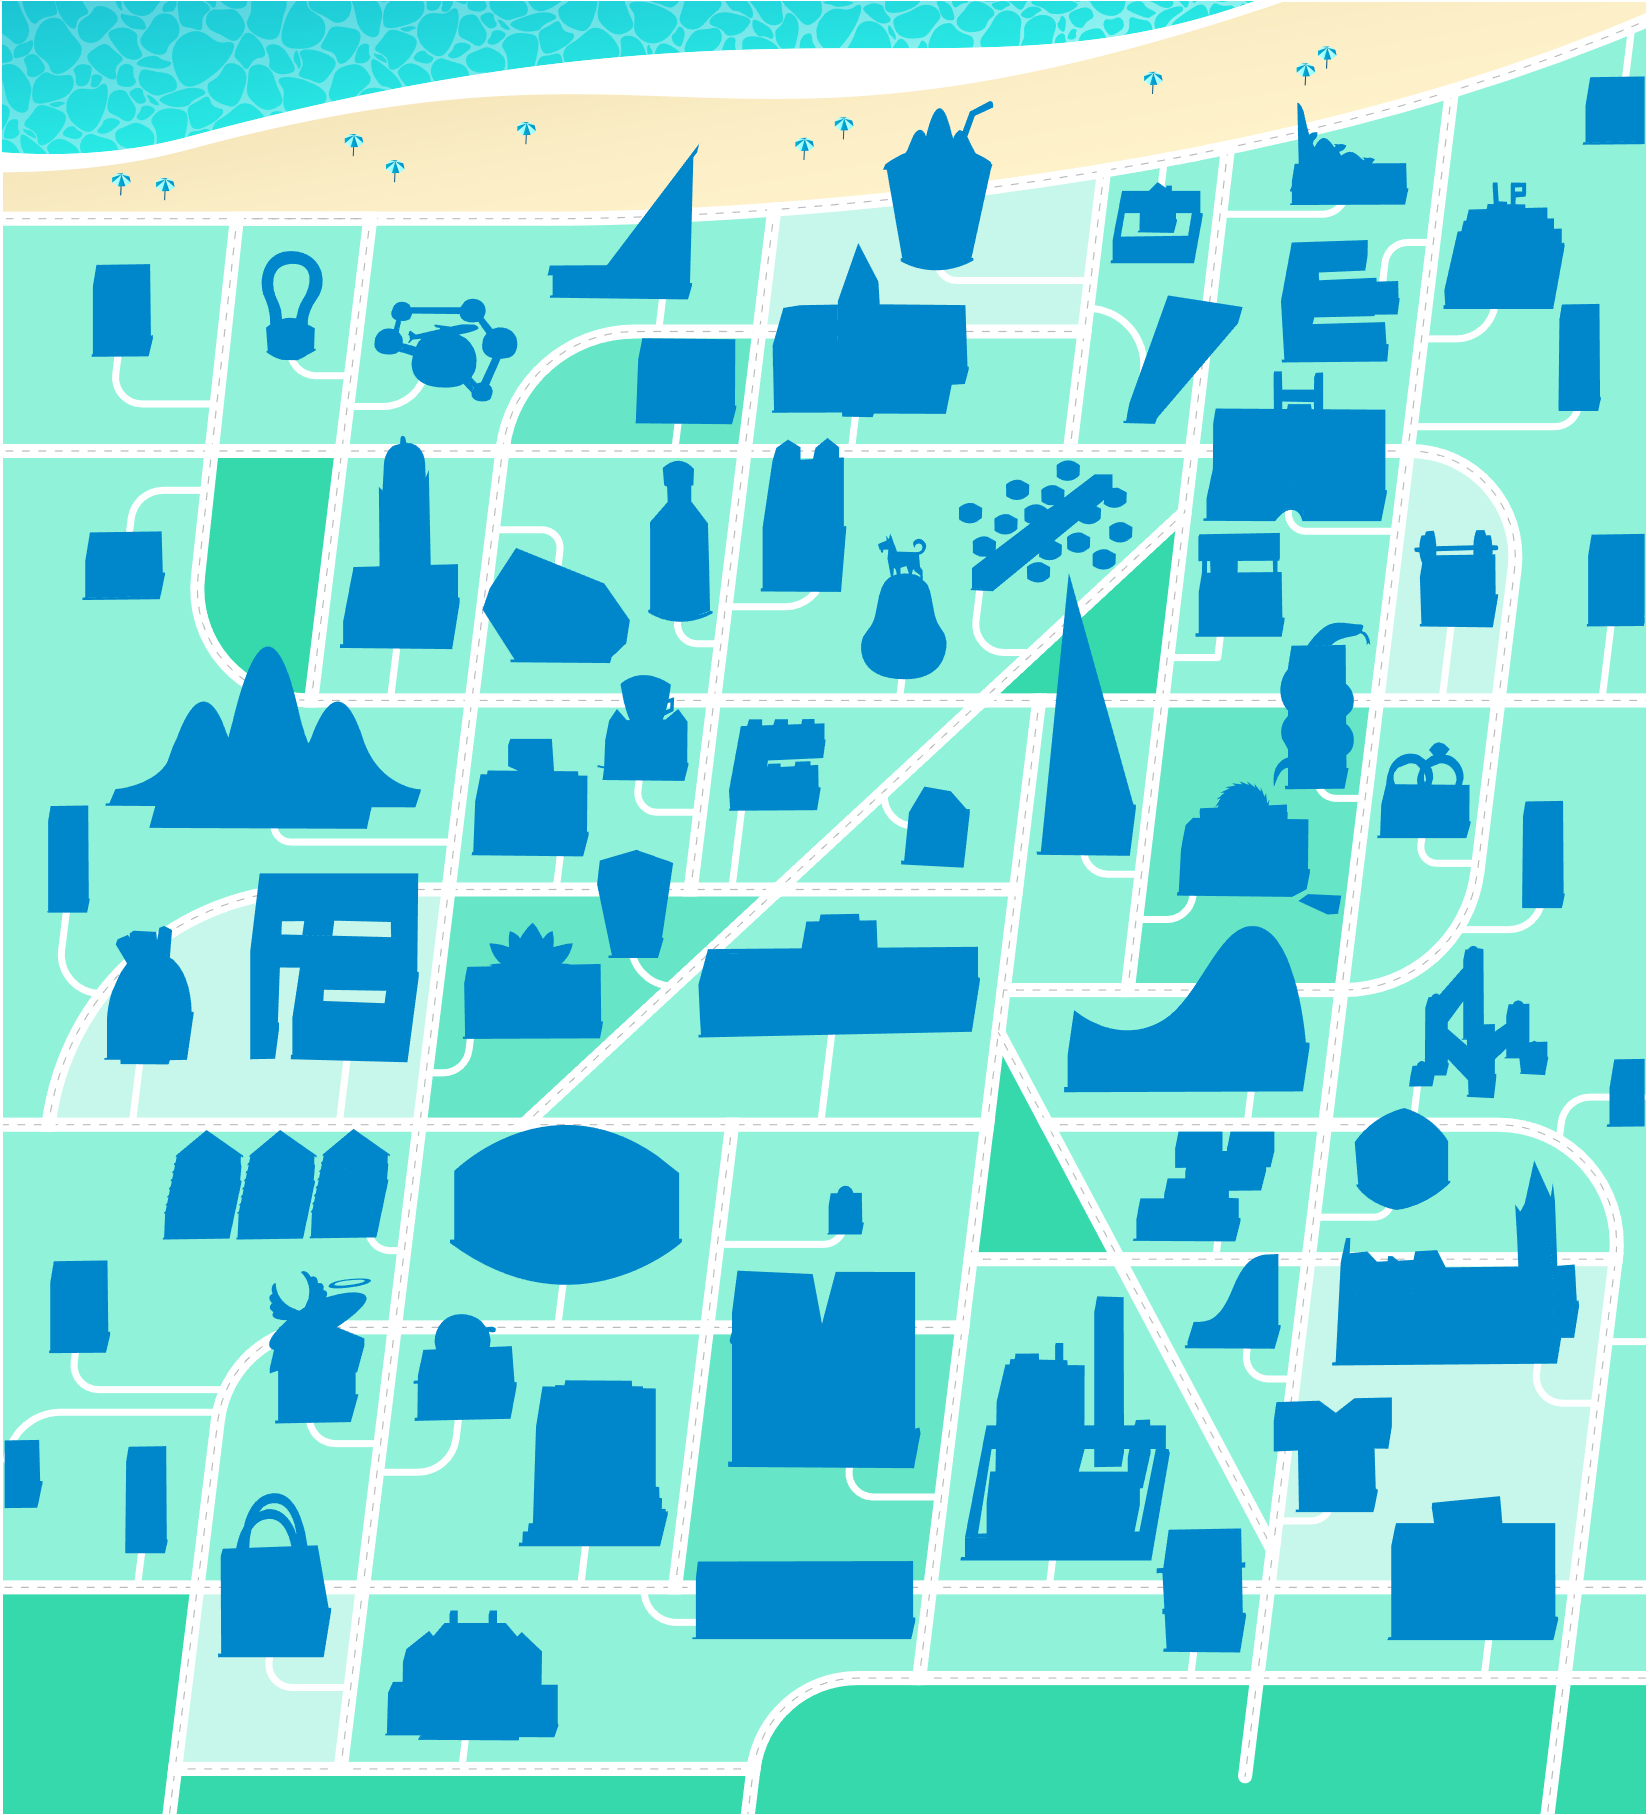

In [14]:
# Plot the solution on the Burritoville Map
placed_trucks = [t for t in x_placed if x_placed[t].X ==1]
show_map(buildings, building_names, building_coordinates, demand, truck_coordinates, placed_trucks = placed_trucks)

## Before you exit, Free Gurobi resources
It is a best practice to free Gurobi resources after you are done.  To do this, call [Model.dispose()](https://www.gurobi.com/documentation/current/refman/py_model_dispose.html#pythonmethod:Model.dispose) on all Model objects, [Env.dispose()](https://www.gurobi.com/documentation/current/refman/py_env_dispose.html#pythonmethod:Env.dispose) on any Env objects you created, or [disposeDefaultEnv()](https://www.gurobi.com/documentation/current/refman/py_disposedefaultenv.html#pythonmethod:disposeDefaultEnv) if you used the default environment instead.

In [15]:
# Free Gurobi resources
model.dispose()
gp.disposeDefaultEnv()

Freeing default Gurobi environment
